# A1: Data Curation
### Jacob Warwick, DATA 512A, October 2018

The author wishes to thank Jonathan Morgan for the use of his [Sample Api Code](http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb).

## Step 1: Data collection
In this step, I collect data from the [English Wikipedia](https://en.wikipedia.org) pageviews and legacy APIs, and then perform some simple data processing tasks to shape the data into a useful format for visualization.

In [224]:
from requests import get as requests_get
from pandas import DataFrame
from json import dump as json_dump

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

params_legacy = {
    "project" : "en.wikipedia.org",
    "access-site" : "desktop-site",
    "granularity" : "monthly",
    "start" : "2001010100",
    "end" : "2018100100"
}

params_pageviews = {
    "project" : "en.wikipedia.org",
    "access" : "desktop",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2001010100",
    "end" : '2018101000'
}

headers = {
    'User-Agent': 'https://github.com/jacobw125',
    'From': 'jacobw42@uw.edu'
}

def gather_legacy_data() -> DataFrame:
    """Function to query the legacy pageviews API for desktop, mobile, and all-sites data, write the response to a file, and
       format it as a DataFrame."""
    all_data = DataFrame()
    for site in ['desktop-site', 'mobile-site', 'all-sites']:
        params_legacy.update({'access-site': site})
        response_data = requests_get(endpoint_legacy.format(**params_legacy), headers=headers).json()
        # Save results of the request to a file for reproducability
        with open('collected_data/{}_{}_{}-{}.json'.format('legacy', site, params_legacy['start'], params_legacy['end']), 'w') as out:
            json_dump(response_data, out)
        all_data = all_data.append(DataFrame(response_data['items']))
    # rename to match the column names of the current pageview API
    all_data.rename({'access-site': 'access', 'count': 'views'}, axis=1, inplace=True)
    all_data['api'] = 'legacy'
    return all_data[['access', 'timestamp', 'views', 'api']]
    
def gather_pageview_data() -> DataFrame:
    """Function to query the current pageview API for desktop, mobile, and all-sites data, write the response to a file, and
       format it as a DataFrame."""
    all_data = DataFrame()
    for access in ['desktop', 'mobile-app', 'mobile-web', 'all-access']:
        params_pageviews.update({'access': access})
        response_data = requests_get(endpoint_pageviews.format(**params_pageviews), headers=headers).json()
        # Save results of the request to a file for reproducability
        with open('collected_data/{}_{}_{}-{}.json'.format('pageview', access, params_pageviews['start'], params_pageviews['end']), 'w') as out:
            json_dump(response_data, out)
        all_data = all_data.append(DataFrame(response_data['items']))
    all_data['api'] = 'pageview'
    return all_data[['access', 'timestamp', 'views', 'api']]

wikipedia_data = gather_legacy_data().append(gather_pageview_data())
print(f"Loaded {len(wikipedia_data)} rows from the API")
print(wikipedia_data.access.value_counts())

Loaded 389 rows from the API
all-sites       105
desktop-site    105
mobile-app       39
desktop          39
all-access       39
mobile-web       39
mobile-site      23
Name: access, dtype: int64


## Step 2: Data Processing
### 2.1 For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
 


In [225]:
mobile_by_month = wikipedia_data[(wikipedia_data['api'] == 'pageview') & (wikipedia_data['access'].map(lambda x: x in ['mobile-app', 'mobile-web']))]
mobile_by_month = mobile_by_month[['timestamp', 'views']].groupby(['timestamp']).sum().reset_index()
mobile_by_month['api'] = 'pageview'
mobile_by_month['access'] = 'total-mobile'
wikipedia_data = wikipedia_data.append(mobile_by_month)
wikipedia_data.access.value_counts()

all-sites       105
desktop-site    105
total-mobile     39
mobile-app       39
desktop          39
all-access       39
mobile-web       39
mobile-site      23
Name: access, dtype: int64

### 2.2 For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

In [226]:
wikipedia_data['year'] = wikipedia_data.timestamp.map(lambda t: t[0:4])
wikipedia_data['month'] = wikipedia_data.timestamp.map(lambda t: t[4:6])
wikipedia_data['day'] = wikipedia_data.timestamp.map(lambda t: t[6:8])
wikipedia_data.head()

,access,api,timestamp,views,year,month,day
0,desktop-site,legacy,2007120100,2998331524,2007,12,01
1,desktop-site,legacy,2008010100,4930902570,2008,01,01
2,desktop-site,legacy,2008020100,4818393763,2008,02,01
3,desktop-site,legacy,2008030100,4955405809,2008,03,01
4,desktop-site,legacy,2008040100,5159162183,2008,04,01


### 2.3 Transform this data into a row-wise CSV

In [227]:
access_renames = {
    'all-sites': 'pagecount_all_views',
    'desktop-site': 'pagecount_desktop_views',
    'mobile-web': 'pagecount_mobile_views',
    'all-access': 'pageview_all_views',
    'desktop': 'pageview_desktop_views',
    'total-mobile': 'pageview_mobile_views'
}
wikipedia_data['access_renamed'] = wikipedia_data.access.map(access_renames)
wikipedia_data.reset_index(drop=True,inplace=True)
wikipedia_data=wikipedia_data[~wikipedia_data['access_renamed'].isnull()] # drop nulls
wikipedia_data = wikipedia_data.pivot_table(index=['year', 'month'], columns='access_renamed', values='views')
wikipedia_data = wikipedia_data.fillna(0)
wikipedia_data.head()

access_renamed  pagecount_all_views  pagecount_desktop_views  \
year month                                                     
2007 12                2.998332e+09             2.998332e+09   
2008 01                4.930903e+09             4.930903e+09   
     02                4.818394e+09             4.818394e+09   
     03                4.955406e+09             4.955406e+09   
     04                5.159162e+09             5.159162e+09   

access_renamed  pagecount_mobile_views  pageview_all_views  \
year month                                                   
2007 12                            0.0                 0.0   
2008 01                            0.0                 0.0   
     02                            0.0                 0.0   
     03                            0.0                 0.0   
     04                            0.0                 0.0   

access_renamed  pageview_desktop_views  pageview_mobile_views  
year month                                                     
2007 12                            0.0                    0.0  
2008 01                            0.0                    0.0  
     02                            0.0                    0.0  
     03                            0.0                    0.0  
     04                            0.0                    0.0

In [228]:
wikipedia_data.to_csv('en-wikipedia_traffic_200801-201709.csv')

## Visualization
In this step, I create a visualization of pageviews by month.

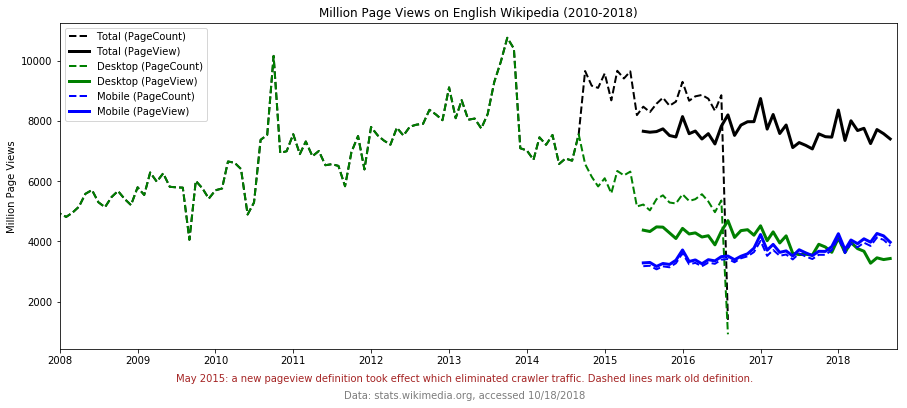

In [258]:
%matplotlib inline
from datetime import datetime
from numpy import nan
date_axis = [datetime(int(dt[0]), int(dt[1]), 1) for dt in list(wikipedia_data.index)]

from matplotlib import pyplot as plt
plt.figure(figsize=(15,6))
plt.plot_date(date_axis, 
              [i if i > 0 else None for i in wikipedia_data.pagecount_all_views/1e6], 
              label='Total (PageCount)', color='black', linestyle='--', linewidth=2, marker=None)
plt.plot_date(date_axis, 
              [i if i > 0 else None for i in wikipedia_data.pageview_all_views/1e6], 
              label='Total (PageView)', color='black', linestyle='-', linewidth=3, marker=None)

plt.plot_date(date_axis, 
              [i if i > 0 else None for i in wikipedia_data.pagecount_desktop_views/1e6], 
              label='Desktop (PageCount)', color='green', linestyle='--', linewidth=2, marker=None)
plt.plot_date(date_axis, 
              [i if i > 0 else None for i in wikipedia_data.pageview_desktop_views/1e6], 
              label='Desktop (PageView)', color='green', linestyle='-', linewidth=3, marker=None)

plt.plot_date(date_axis, 
              [i if i > 0 else None for i in wikipedia_data.pagecount_mobile_views/1e6], 
              label='Mobile (PageCount)', color='blue', linestyle='--', linewidth=2, marker=None)
plt.plot_date(date_axis, 
              [i if i > 0 else None for i in wikipedia_data.pageview_mobile_views/1e6], 
              label='Mobile (PageView)', color='blue', linestyle='-', linewidth=3, marker=None)
plt.title("Million Page Views on English Wikipedia (2010-2018)")
plt.ylabel("Million Page Views")
plt.xlim((datetime(2008, 1, 1), datetime(2018, 10, 1)))
plt.legend(loc='upper left')
plt.figtext(0.5, 0.05, 
            'May 2015: a new pageview definition took effect which eliminated crawler traffic. ' +
            'Dashed lines mark old definition.',
            horizontalalignment='center', color="#A52525") 
plt.figtext(0.50, 0.01, 
            'Data: stats.wikimedia.org, accessed 10/18/2018', 
            horizontalalignment='center', color='#7d7d7d') 
plt.plot(dpi=200)
plt.savefig("figure_1_million_page_views_over_time.png", dpi=200)

The Desktop and Total PageCount numbers take a nosedive around mid-2016, which seems pretty odd. My guess is that the system was turned off partway through the month, which affected the monthly total:

In [263]:
tmp = wikipedia_data.reset_index()
tmp.loc[
    (tmp['year'] == '2016') & (tmp['month'].map(lambda x: 10 > int(x) > 3)), 
    ['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views']
]

access_renamed,year,month,pagecount_all_views,pagecount_desktop_views
100,2016,04,8.873621e+09,5.572235e+09
101,2016,05,8.748968e+09,5.330532e+09
102,2016,06,8.347711e+09,4.975092e+09
103,2016,07,8.864628e+09,5.363966e+09
104,2016,08,1.393717e+09,9.136759e+08
105,2016,09,0.000000e+00,0.000000e+00


I regard removing data as a dangerous manipulation that often introduces bias into experiments, so I decided against removing that month from the visualization.